## Python Econometric Implementation

### Packages

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from linearmodels.panel import PanelOLS

### Inputs

In [3]:
livneh_filepath = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/Livneh_historical_county_obs.csv"
usda_filepath = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/usda_historical_yields.csv"
livneh_pd = pd.read_csv(livneh_filepath)
usda_pd = pd.read_csv(usda_filepath)

### Preprocessing

In [4]:
# pads usda_pd with zeros, and subsets
usda_pd['fips'] = usda_pd['fips'].astype(str).str.zfill(5)
usda_pd['state'] = usda_pd['state'].astype(str).str.zfill(2)
usda_pd = usda_pd[['fips','year','yield', 'state']]
# Count occurrences of 'fips' and name the column 'n'
fips_counts = usda_pd.groupby('fips').size().reset_index(name='n')
# Merge the count back into the original DataFrame
usda_pd = usda_pd.merge(fips_counts, on='fips')
usda_pd = usda_pd[usda_pd["n"] >= 30]

usda_pd['log_yield'] = np.log(usda_pd['yield'])

livneh_pd['fips'] = livneh_pd['fips'].astype(str).str.zfill(5)
livneh_pd['state'] = livneh_pd['fips'].astype(str).str.slice(0, 2)

# merge usda_pd & livneh_pd 
df = livneh_pd.merge(usda_pd, how='inner', on=['fips', 'year', 'state'])
df['year2'] = df['year']**2

rainfed_states = ["01", "05", "09", "10", "12", "13", "17", "18", "19", "20", 
                   "21", "22", "23", "24", "25", "26", "27", "28", "29", "31", 
                   "33", "34", "36", "37", "38", "39", "40", "42", "44", "45", 
                   "46", "47", "48", "50", "51", "54", "55"]

df = df[df['state'].isin(rainfed_states)]


## Econometric Model Implementation non-pyWBM

### Schelnker & Roberts 2009

In [17]:
# https://www.pnas.org/doi/10.1073/pnas.0906865106
# We use county-level trends and then model the year-to-year variations
# via growing degree days (GDD), extreme degree days (EDD), season-total precip (prcp)
# and season-total precip squared (prcp2)
fips_number = '17113'
df_set_index = df.set_index(['fips', 'year'])

# Define the model with both entity and time fixed effects
model = PanelOLS.from_formula('log_yield ~ GDD + EDD + prcp + prcp2 + EntityEffects + TimeEffects', data=df_set_index)

# Fit the model
results_sr09 = model.fit()

In [18]:
GDD_param = results_sr09.params.GDD.item()
EDD_param = results_sr09.params.EDD.item()
prcp_param = results_sr09.params.prcp.item()
prcp2_param = results_sr09.params.prcp2.item()
entity_effect = results_sr09.estimated_effects['estimated_effects'].loc[f'{fips_number}'].values
df_fip_01001 = df[df['fips'] == f'{fips_number}']
model_predication_sr09 = (GDD_param * df_fip_01001['GDD'] + 
                     EDD_param * df_fip_01001['EDD'] + 
                     prcp_param * df_fip_01001['prcp'] + 
                     prcp2_param * df_fip_01001['prcp2'] +
                    entity_effect)

### Haqiqi et al. 2021

In [19]:
# https://hess.copernicus.org/articles/25/551/2021/hess-25-551-2021.pdf
# Again use county-level trends, now model the year-to-year variations
# via growing degree days (GDD), extreme degree days conditioned on soil moisture buckets,
# season-average soil moisture (SM_mean) and season-average soil squared (SM_mean2)
output_dir = "/storage/home/cta5244/work/avila_et_al_2026_pyWBM_yield/0_uncertainity_figures/fips_nonpywbm_models"

df_set_index = df.set_index(['fips', 'year'])

# Define the model with both entity and time fixed effects
model = PanelOLS.from_formula(
    ('log_yield ~ GDD + EDD_SM_75_below + EDD_SM_25_75_below + EDD_SM_0_25_norm + EDD_SM_25_75_above + EDD_SM_75_above + SM_mean + SM_mean2 + EntityEffects + TimeEffects'),
    data=df_set_index)

# Fit the model
results_h21 = model.fit()

In [20]:
GDD_param = results_h21.params.GDD.item()
EDD_SM_75_below_param = results_h21.params.EDD_SM_75_below.item()
EDD_SM_25_75_below_param = results_h21.params.EDD_SM_25_75_below.item()
EDD_SM_0_25_norm_param = results_h21.params.EDD_SM_0_25_norm.item()
EDD_SM_25_75_above_param = results_h21.params.EDD_SM_25_75_above.item()
EDD_SM_75_above_param = results_h21.params.EDD_SM_75_above.item()
SM_mean_param = results_h21.params.SM_mean.item()
SM_mean2_param = results_h21.params.SM_mean2.item()
entity_effect = results_h21.estimated_effects['estimated_effects'].loc[f'{fips_number}'].values


df_fip_01001 = df[df['fips'] == f'{fips_number}']
model_predication_h21 = (GDD_param * df_fip_01001['GDD'] + 
                     EDD_SM_75_below_param * df_fip_01001['EDD_SM_75_below'] + 
                     EDD_SM_25_75_below_param * df_fip_01001['EDD_SM_25_75_below'] + 
                     EDD_SM_0_25_norm_param * df_fip_01001['EDD_SM_0_25_norm'] +
                     EDD_SM_25_75_above_param * df_fip_01001['EDD_SM_25_75_above'] +
                     EDD_SM_75_above_param * df_fip_01001['EDD_SM_75_above'] +
                     SM_mean_param * df_fip_01001['SM_mean'] +
                     SM_mean2_param * df_fip_01001['SM_mean2'] +
                    entity_effect)

### Plotting

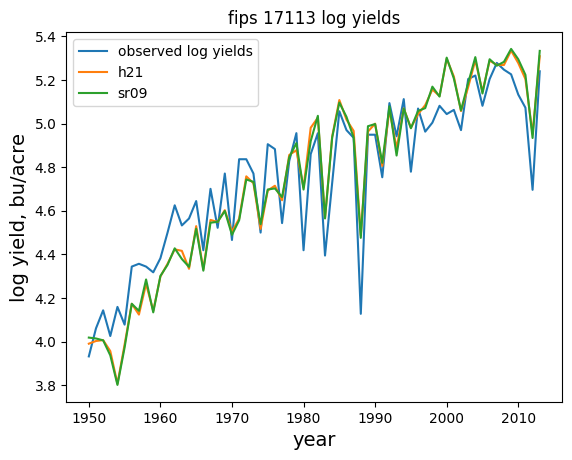

In [21]:
plt.plot(df_fip_01001['year'], df_fip_01001['log_yield'], label='observed log yields')
plt.plot(df_fip_01001['year'],  model_predication_h21, label='h21')
plt.plot(df_fip_01001['year'],  model_predication_sr09, label='sr09')
plt.title(f'fips {fips_number} log yields')
plt.ylabel('log yield, bu/acre', fontsize=14)
plt.xlabel('year', fontsize=14)
plt.legend()

Text(0.5, 1.0, 'correlation fips 17113')

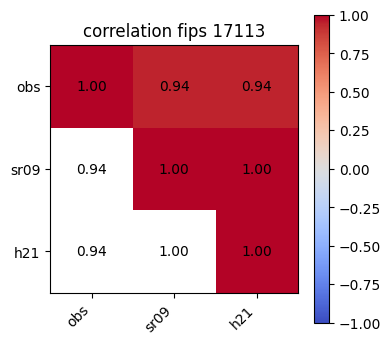

In [22]:
data_dict = {
    'obs': df_fip_01001['year'],
    'sr09': model_predication_sr09,
    'h21': model_predication_h21
}

df_corr = pd.DataFrame(data_dict)

# Calculate the correlation matrix
correlation_matrix = df_corr.corr()

plt.figure(figsize=(4, 4))  # Adjust size as needed

uppermatrix = np.triu(correlation_matrix)
uppermatrix_nan = np.where(uppermatrix == 0, np.nan, uppermatrix)

im = plt.imshow(uppermatrix_nan, cmap='coolwarm', vmax=1, vmin=-1)
plt.colorbar(im)
labels = correlation_matrix.columns
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.yticks(range(len(labels)), labels)

for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', 
                ha='center', va='center')
plt.title(f'correlation fips {fips_number}')

## Econometric Model Implementation pyWBM

In [30]:
forcings_path = "/storage/work/cta5244/pyWBM_yield_data/LOCA2_ssp/tasmin.GFDL-CM4.ssp245.r1i1p1f1.2015-2044.LOCA_16thdeg_v20220413.nc"
nldas_smap = "/storage/group/pches/default/users/dcl5300/wbm_soilM_uc_2024_DATA/misc/"
forcings_future_tas = xr.open_dataset(forcings_path)
forcings_future_tas

<xarray.Dataset> Size: 20GB
Dimensions:  (time: 10958, lat: 474, lon: 944)
Coordinates:
  * time     (time) datetime64[ns] 88kB 2015-01-01T12:00:00 ... 2044-12-31T12...
  * lat      (lat) float32 2kB 23.91 23.97 24.03 24.09 ... 53.34 53.41 53.47
  * lon      (lon) float32 4kB 234.5 234.6 234.7 234.7 ... 293.3 293.4 293.5
Data variables:
    tasmin   (time, lat, lon) float32 20GB ...
Attributes: (12/215)
    input1_SIOCRD_netCDF_Version:               1.0
    input1_title:                               LOCA statistically downscaled...
    input1_history:                             File was processed by fremeta...
    input1_external_variables:                  areacella
    input1_table_id:                            day
    input1_activity_id:                         CMIP
    ...                                         ...
    input2_fname_gcm_in:                        ../../Models/GFDL-CM4/0p5x0p5...
    input2_experiment:                          
    input2_loca_post_ds_bc_id:                  $Id: loca_post_ds_bc.F90,v 1....
    input2_loca_post_ds_bc_source:              $Source: /home6/dwpierc2/src/...
    history:                                    Thu Apr 28 09:23:14 2022: ncr...
    NCO:                                        4.6.7